# Wasserstein Generative Adversarial Network (WGAN)

#### ▢ GAN의 단점 보완
    (1) Wasserstein Loss
      ↪ 실제 데이터 분포와 생성된 데이터 분포 간의 거리(Wasserstein distance)를 손실함수에 반영하여 기존 GAN의 손실함수(BCELoss)가 가지던 문제점 해결

        ✔ 기존 GAN의 손실함수가 가지던 문제
            1. Vanishing Gradient : Discriminator가 Generator에 비해 성능이 훨씬 뛰어날 경우, 출력이 0 또는 1에 가까워지며 로그 함수의 gradient가 소실되어 학습 효과가 없어지는 현상

            2. mode collapse : Generator가 다양한 이미지를 생성하지 못하고 비슷한 이미지만 계속 생성해내는 현상. Discriminator를 속이기 쉬운 특정한 레이블(최빈값, mode)만 생성하게 됨.

    (2) Lipschitz Constraint
        ↪ Discriminator의 가중치가 Lipshitz 연속함수의 조건을 만족하도록 제약조건을 걸어줌. 학습 도중 발산하는 현상을 방지.

    (3) Discriminator의 sigmoid layer 제거
        ↪ 최종 출력을 확률로 제한하지 않기 때문에, Discriminator가 더 넓은 범위의 출력을 가져 학습을 더욱 안정화 시킴.

#### ▢ 확률 분포간의 거리를 나타내는 지표
    (1) Total Variation(TV)
        ↪ 두 확률측도의 측정값이 벌어질 수 있는 값 중 가장 큰 값, 거리의 모든 요소 A ∈ Σ 중 가장 큰 거리

            - x와 분포와 y의 분포가 겹치지 않을때, x에서 A를 찾을 가장 큰 확률 100 %
            - x와 분포와 y의 분포가 겹치지 않을때, y에서 A를 찾을 찾을 가장 낮은 확률 0 %
            - A : 발생할 수 있는 경우의 수의 범위 (100 % - 0 % = 100 %)
            
    (2) KL Divergence
        ↪ 어떤 이상적인 확률분포(p)에 대해, 그 분포를 근사하는 다른 분포(q)를 사용해 샘플링할 때 발생할 수 있는 정보 엔트로피의 차이

        - KL Divergence의 특징
            1) KL(p|q)≥0
            2) KL(p|q)≠KL(q|p) (KL divergence는 거리 개념이 아님)

    (3) JS Divergence
        ↪ Θ==0일때 0, Θ!=0일때 log2

    (4) Earth Mover's Distance(EM), Wasserstein Distance
        ↪ 모든 결합확률분포 중에서 d(X, Y)의 기대값을 가장 작게 추정한 값(기대값 사이의 거리를 측정)

        - π(x, y) : 두 확률분포의 결합, γ : 그 요소 중 하나
        - 요소를 뽑았을 때 대응하는 X, Y가 분포하는 모양은 변하지 않지만, 경향은 달라지게 됨.
        - 뽑은 여러가지 γ 중에서 d(X, Y)의 기대값이 가장 작게 나오는 확률분포를 취함.
        
#### ▢ WGAN에서 확률 분포 간 거리를 측정할 때 EM을 사용하는 이유
        ↪ TV, KL, JS는 두 분포가 겹치는 경우 0, 겹치지 않는 경우엔 무한대 또는 상수로 비연속적이고 극단 값을 가짐.
        따라서 gradient가 제대로 전달되지 않아 학습이 어려움.



    https://velog.io/@tobigs-gm1/basicofgan
    https://www.slideshare.net/ssuser7e10e4/wasserstein-gan-i


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
# latent vector를 뽑기 위한 noise 분포의 dimension
latent_dim = 100

# 일반적인 딥러닝 모델의 목표 : 데이터의 연산 결과와 실제 값의 차가 작아지도록

# 생성자의 목표 : 가짜 이미지를 생성하여 판별자가 그것을 real로 판별하도록 속이기
# 판별자의 연산 결과(0-속이기 실패 or 1-속이기 성공)와 실제 값(1)의 차(loss)를 줄이는 것
# Generator
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C (number of channels)
        self.main_module = nn.Sequential(
            # Z latent vector 100
            nn.ConvTranspose2d(in_channels=100, out_channels=256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (1024x4x4)
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(True),

            # State (512x8x8)
            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(True),

            # State (256x16x16)
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2, padding=2))
            # output of main module --> Image (Cx32x32)

        self.output = nn.Tanh()

    def forward(self, x):
        x = x.unsqueeze(dim=-1).unsqueeze(dim=-1)
        x = self.main_module(x)  # x : [batch_size, 100] 무작위의 100차원 latent_dim을 입력받아
        return self.output(x)


# 판별자의 목표 : 생성자가 만든 가짜 이미지와 실제 이미지를 구별하기
# 판별자의 연산 결과(0-판별 성공 or 1-판별 실패)와 실제 값(0)의 차(loss)를 줄이는 것
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Filters [256, 512, 1024]
        # Input_dim = channels (Cx64x64)
        # Output_dim = 1
        self.main_module = nn.Sequential(
            # Image (Cx32x32)
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            # State (256x16x16)
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State (512x8x8)
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True))
            # outptut of main module --> State (1024x4x4)

        self.output = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=0),
            # Output 1
        )

    def forward(self, x):
        x = self.main_module(x)
        return self.output(x)

In [3]:
# 학습 데이터 셋 MNIST 불러오기

transforms_train = transforms.Compose([
    transforms.Resize(28), # 이미지 크기를 28*28로 조절
    transforms.ToTensor(), # 이미지를 tensor type으로 변환
    transforms.Normalize([0.5], [0.5]) # 이미지 정규화. 픽셀 값 범위 -1 ~ 1, 평균 0.5, 표준편차 0.5
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 225832217.51it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38455775.82it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 122533112.39it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 5412082.04it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [6]:
lr = 0.0001
generator = Generator().to(device)
discriminator = Discriminator().to(device)

##
# Adam 대신 RMSprop 사용 : RMSprop에는 Adam과 달리 모멘텀(과거의 기울기 고려)을 사용하지 않음
# WGAN에서는 Adam 대신 RMSprop과 기울기 클리핑을 함께 사용하여 훈련 안정성을 높임
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

In [7]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

n_epochs = 50
sample_interval = 2000
start_time = time.time()

for epoch in tqdm(range(n_epochs)) :
    for i, (imgs, _) in enumerate(dataloader) :
        real = torch.FloatTensor(imgs.size(0), 1, 1, 1).fill_(1.0).to(device) # [batch_size, 1] : 1
        fake = torch.FloatTensor(imgs.size(0), 1, 1, 1).fill_(0.0).to(device) # [batch_size, 1] : 0

        real_imgs = imgs.to(device) # [batch_size, 1, 28, 28]

        # 랜덤 노이즈 샘플링
        x = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).to(device) # [batch_size, latent_dim, 1, 1]의 정규분포(연속확률분포)

    ### 생성자
        optimizer_G.zero_grad()

        # 생성자 이미지 생성
        generated_imgs = generator(x)

        ## -mean(D(G(z))) as generator loss
        g_loss = -torch.mean(discriminator(generated_imgs))

        # 생성자 업데이트
        g_loss.backward()
        optimizer_G.step()

    ### 판별자
        optimizer_D.zero_grad()

        ## mean(D(G(z))) - mean(D(x)) as discriminator loss
        real_loss = torch.mean(discriminator(real_imgs))
        fake_loss = torch.mean(discriminator(generated_imgs.detach()))
        d_loss = fake_loss - real_loss

        # 판별자 업데이트
        d_loss.backward()
        optimizer_D.step()

        ## 기울기 클리핑
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        done = epoch * len(dataloader) + i # 전체 판독 수 (epoch * num_batch)

        if done % sample_interval == 0 :
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f'2_{done}.png', nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

  2%|▏         | 1/50 [00:29<24:05, 29.50s/it]

[Epoch 0/50] [D loss: -0.708815] [G loss: 0.357181] [Elapsed time: 29.50s]


  4%|▍         | 2/50 [00:58<23:19, 29.15s/it]

[Epoch 1/50] [D loss: -0.101457] [G loss: 0.091283] [Elapsed time: 58.41s]


  6%|▌         | 3/50 [01:28<23:06, 29.50s/it]

[Epoch 2/50] [D loss: -0.046164] [G loss: -0.088618] [Elapsed time: 88.32s]


  8%|▊         | 4/50 [01:58<22:45, 29.69s/it]

[Epoch 3/50] [D loss: -0.080124] [G loss: -0.081197] [Elapsed time: 118.30s]


 10%|█         | 5/50 [02:27<22:13, 29.64s/it]

[Epoch 4/50] [D loss: -0.030947] [G loss: 0.047203] [Elapsed time: 147.85s]


 12%|█▏        | 6/50 [02:57<21:45, 29.67s/it]

[Epoch 5/50] [D loss: -0.070591] [G loss: 0.074200] [Elapsed time: 177.58s]


 14%|█▍        | 7/50 [03:27<21:16, 29.69s/it]

[Epoch 6/50] [D loss: -0.050991] [G loss: 0.078360] [Elapsed time: 207.31s]


 16%|█▌        | 8/50 [03:57<20:47, 29.70s/it]

[Epoch 7/50] [D loss: -0.046824] [G loss: 0.004818] [Elapsed time: 237.03s]


 18%|█▊        | 9/50 [04:26<20:17, 29.70s/it]

[Epoch 8/50] [D loss: -0.027429] [G loss: -0.034948] [Elapsed time: 266.72s]


 20%|██        | 10/50 [04:56<19:48, 29.72s/it]

[Epoch 9/50] [D loss: -0.027425] [G loss: 0.058894] [Elapsed time: 296.49s]


 22%|██▏       | 11/50 [05:26<19:19, 29.73s/it]

[Epoch 10/50] [D loss: 0.037483] [G loss: -0.088705] [Elapsed time: 326.24s]


 24%|██▍       | 12/50 [05:55<18:50, 29.74s/it]

[Epoch 11/50] [D loss: -0.011907] [G loss: -0.102972] [Elapsed time: 356.00s]


 26%|██▌       | 13/50 [06:25<18:19, 29.72s/it]

[Epoch 12/50] [D loss: -0.044024] [G loss: -0.005561] [Elapsed time: 385.69s]


 28%|██▊       | 14/50 [06:55<17:50, 29.73s/it]

[Epoch 13/50] [D loss: -0.029484] [G loss: -0.017043] [Elapsed time: 415.43s]


 30%|███       | 15/50 [07:25<17:21, 29.75s/it]

[Epoch 14/50] [D loss: 0.000962] [G loss: -0.058996] [Elapsed time: 445.23s]


 32%|███▏      | 16/50 [07:54<16:51, 29.75s/it]

[Epoch 15/50] [D loss: -0.025666] [G loss: 0.045582] [Elapsed time: 474.99s]


 34%|███▍      | 17/50 [08:24<16:22, 29.78s/it]

[Epoch 16/50] [D loss: -0.013344] [G loss: -0.083263] [Elapsed time: 504.82s]


 36%|███▌      | 18/50 [08:54<15:52, 29.77s/it]

[Epoch 17/50] [D loss: 0.011338] [G loss: 0.046548] [Elapsed time: 534.58s]


 38%|███▊      | 19/50 [09:24<15:22, 29.76s/it]

[Epoch 18/50] [D loss: -0.013653] [G loss: 0.198441] [Elapsed time: 564.31s]


 40%|████      | 20/50 [09:54<14:52, 29.76s/it]

[Epoch 19/50] [D loss: -0.007540] [G loss: 0.047118] [Elapsed time: 594.09s]


 42%|████▏     | 21/50 [10:23<14:23, 29.76s/it]

[Epoch 20/50] [D loss: -0.022059] [G loss: -0.074377] [Elapsed time: 623.85s]


 44%|████▍     | 22/50 [10:53<13:53, 29.76s/it]

[Epoch 21/50] [D loss: -0.019334] [G loss: 0.124401] [Elapsed time: 653.61s]


 46%|████▌     | 23/50 [11:23<13:23, 29.77s/it]

[Epoch 22/50] [D loss: 0.006676] [G loss: 0.009065] [Elapsed time: 683.38s]


 48%|████▊     | 24/50 [11:53<12:54, 29.77s/it]

[Epoch 23/50] [D loss: -0.003352] [G loss: 0.064181] [Elapsed time: 713.16s]


 50%|█████     | 25/50 [12:22<12:24, 29.77s/it]

[Epoch 24/50] [D loss: 0.008262] [G loss: 0.148067] [Elapsed time: 742.95s]


 52%|█████▏    | 26/50 [12:52<11:55, 29.79s/it]

[Epoch 25/50] [D loss: 0.000351] [G loss: -0.187355] [Elapsed time: 772.78s]


 54%|█████▍    | 27/50 [13:22<11:25, 29.79s/it]

[Epoch 26/50] [D loss: -0.021096] [G loss: 0.016918] [Elapsed time: 802.57s]


 56%|█████▌    | 28/50 [13:52<10:55, 29.78s/it]

[Epoch 27/50] [D loss: -0.023847] [G loss: 0.102813] [Elapsed time: 832.34s]


 58%|█████▊    | 29/50 [14:22<10:25, 29.77s/it]

[Epoch 28/50] [D loss: -0.014831] [G loss: 0.116409] [Elapsed time: 862.07s]


 60%|██████    | 30/50 [14:51<09:55, 29.76s/it]

[Epoch 29/50] [D loss: -0.013055] [G loss: 0.210350] [Elapsed time: 891.82s]


 62%|██████▏   | 31/50 [15:21<09:25, 29.76s/it]

[Epoch 30/50] [D loss: -0.013923] [G loss: -0.071584] [Elapsed time: 921.58s]


 64%|██████▍   | 32/50 [15:51<08:55, 29.77s/it]

[Epoch 31/50] [D loss: -0.006929] [G loss: -0.137057] [Elapsed time: 951.37s]


 66%|██████▌   | 33/50 [16:21<08:26, 29.77s/it]

[Epoch 32/50] [D loss: -0.024666] [G loss: 0.118776] [Elapsed time: 981.15s]


 68%|██████▊   | 34/50 [16:50<07:56, 29.78s/it]

[Epoch 33/50] [D loss: 0.004719] [G loss: 0.131788] [Elapsed time: 1010.94s]


 70%|███████   | 35/50 [17:20<07:26, 29.79s/it]

[Epoch 34/50] [D loss: 0.050297] [G loss: -0.031096] [Elapsed time: 1040.77s]


 72%|███████▏  | 36/50 [17:50<06:57, 29.81s/it]

[Epoch 35/50] [D loss: 0.007341] [G loss: -0.006592] [Elapsed time: 1070.60s]


 74%|███████▍  | 37/50 [18:20<06:27, 29.82s/it]

[Epoch 36/50] [D loss: -0.007190] [G loss: -0.020743] [Elapsed time: 1100.46s]


 76%|███████▌  | 38/50 [18:50<05:57, 29.80s/it]

[Epoch 37/50] [D loss: -0.016813] [G loss: 0.019504] [Elapsed time: 1130.23s]


 78%|███████▊  | 39/50 [19:20<05:27, 29.80s/it]

[Epoch 38/50] [D loss: -0.000016] [G loss: -0.130734] [Elapsed time: 1160.02s]


 80%|████████  | 40/50 [19:49<04:58, 29.81s/it]

[Epoch 39/50] [D loss: -0.007135] [G loss: -0.050426] [Elapsed time: 1189.84s]


 82%|████████▏ | 41/50 [20:19<04:28, 29.82s/it]

[Epoch 40/50] [D loss: -0.000341] [G loss: 0.026380] [Elapsed time: 1219.68s]


 84%|████████▍ | 42/50 [20:49<03:58, 29.81s/it]

[Epoch 41/50] [D loss: -0.011655] [G loss: 0.067856] [Elapsed time: 1249.48s]


 86%|████████▌ | 43/50 [21:19<03:28, 29.81s/it]

[Epoch 42/50] [D loss: 0.004841] [G loss: 0.035295] [Elapsed time: 1279.28s]


 88%|████████▊ | 44/50 [21:49<02:58, 29.82s/it]

[Epoch 43/50] [D loss: -0.004374] [G loss: 0.017150] [Elapsed time: 1309.11s]


 90%|█████████ | 45/50 [22:18<02:29, 29.83s/it]

[Epoch 44/50] [D loss: 0.002440] [G loss: -0.001235] [Elapsed time: 1338.97s]


 92%|█████████▏| 46/50 [22:48<01:59, 29.83s/it]

[Epoch 45/50] [D loss: 0.007694] [G loss: -0.043172] [Elapsed time: 1368.80s]


 94%|█████████▍| 47/50 [23:18<01:29, 29.83s/it]

[Epoch 46/50] [D loss: -0.000521] [G loss: 0.046651] [Elapsed time: 1398.64s]


 96%|█████████▌| 48/50 [23:48<00:59, 29.83s/it]

[Epoch 47/50] [D loss: -0.000451] [G loss: -0.000670] [Elapsed time: 1428.47s]


 98%|█████████▊| 49/50 [24:18<00:29, 29.82s/it]

[Epoch 48/50] [D loss: -0.013328] [G loss: 0.003418] [Elapsed time: 1458.25s]


100%|██████████| 50/50 [24:48<00:00, 29.76s/it]

[Epoch 49/50] [D loss: 0.009158] [G loss: 0.018678] [Elapsed time: 1488.03s]


In [8]:
save_image(generated_imgs.data[:25], f'2_{done}.png', nrow=5, normalize=True)

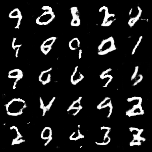

In [9]:
from IPython.display import Image

Image('2_93749.png')